<a href="https://colab.research.google.com/github/Ana-AlonsoCanizares/AA_GRUPO3/blob/main/PruebaControl_OCASO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Medición Prueba de Control
Archivo para medir las diferencias de accesos y lecturas en el grupo experimental frente al de control **(OJO, hay que añadir tb la parte de producción y tendencia).**

Diariamente se descargan los datos de la auditoria de los usuarios desde el lunes sábado 13 de Abril de 2024 a las 00:00 horas hasta el momento actual.

In [14]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.1 MB/s eta 0:00:00


In [80]:
import os
import pandas as pd
import numpy as np
from unidecode import unidecode
import matplotlib.pyplot as plt

Defino el grupo experimental como Gr1 y el de control como Gr2.

Hay que tener en cuenta que agentes_inicio son todos los agentes que había el viernes 12 de Abril, se hará un cruce con los agentes del grupo experimental para crear el Gr1.

##Archivos necesarios
Auditoria (descargar todos los días), estructura comercial, grupo control, estandar grupo experimental y formacion grupo experimental.

Subir todos al colab para ser ejecutados.

In [167]:
accesos_usuarios_df = pd.read_excel('/content/2.13_Auditoria_usuarios.xlsx')
agentes_inicio = pd.read_excel('/content/1.18_Estructura_Comercial.xlsx')
Gr2 = pd.read_excel('/content/1.18_Grupo_de_control.xlsx')
est_gr_exp = pd.read_excel('/content/estandar_gr_exp.xlsx')
for_gr_exp = pd.read_excel('/content/formacion_gr_exp.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [165]:
def cols_to_keep(df):
  cols = ['SUCURSAL', 'OFICINA', 'PV', 'CODIGO', 'COD. CALLIDUS/SOLNET', 'LDAP', 'NIF', 'NOMBRE', 'TIPOLOGIA', 'F.ALTA']
  df = df[cols]
  return df

def clean_df(df):
    # Convertir todas las columnas de tipo object a mayúsculas, excepto las especificadas
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)

    # Ahora, aplicamos unidecode a los nombres de las columnas
    df.columns = [unidecode(col.upper()) for col in df.columns]
    return df

def date_delete(df):
    df['DIA'] = df['FECHA ESPANOLA'].dt.day
    df['MES'] = df['FECHA ESPANOLA'].dt.month
    # Elimino la columna unnamed y la fecha del servidor, ya que nos vamos a quedar solo con la fecha española
    del_columns = ['UNNAMED: 0', 'FECHA SERVIDOR']
    df.drop(columns=del_columns, inplace=True)
    return df

In [168]:
accesos_usuarios_df = clean_df(accesos_usuarios_df)
accesos_usuarios_df = date_delete(accesos_usuarios_df)
agentes_inicio = cols_to_keep(agentes_inicio)
agentes_inicio = clean_df(agentes_inicio)
Gr2 = cols_to_keep(Gr2)
Gr2 = clean_df(Gr2)
for_gr_exp = clean_df(for_gr_exp)
est_gr_exp = clean_df(est_gr_exp)

<ipython-input-165-a586ba754510>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)
<ipython-input-165-a586ba754510>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].apply(lambda x: unidecode(x.upper()) if isinstance(x, str) else x)
<ipython-input-165-a586ba754510>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [83]:
gr_exp = pd.concat([for_gr_exp, est_gr_exp], ignore_index=True)

In [170]:
Gr1 = agentes_inicio[agentes_inicio['COD. CALLIDUS/SOLNET'].isin(gr_exp['NAME'])]

La columna 'LDAP' es el código que identifica al agente en los archivos Gr1 y Gr2, y 'USERID' en accesos_usuarios_df, los que hay que tener en cuenta al cruzar los dataframes.

Los mezclo para quedarme con todas las columnas y poder hablar de sucursales y otros conceptos.

In [172]:
accesos_gr_exp = pd.merge(accesos_usuarios_df, Gr1, how = 'inner', left_on = 'USERID', right_on = 'LDAP')
accesos_gr_ctrl = pd.merge(accesos_usuarios_df, Gr2, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

In [173]:
dif_eventos_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO'], as_index=False).count()
dif_eventos_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO'], as_index=False).count()

**OJO: ¿cómo puedo cambiar la leyenda?**

<ipython-input-174-5df703c00b45>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


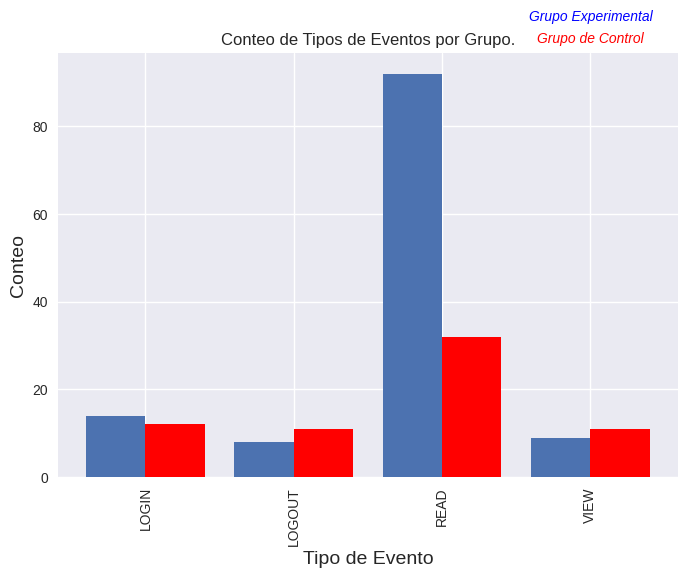

In [174]:
plt.style.use('seaborn')
ax = dif_eventos_exp['USERID'].plot(kind="bar", width=-0.4, rot=0, stacked=True, align='edge')
dif_eventos_ctrl['USERID'].plot(ax=ax, width=0.4, kind="bar",align='edge', color="red")
ax.set_xticklabels(dif_eventos_exp['TIPO EVENTO'])
ax.set_ylabel('Conteo', fontsize = 14)
ax.set_xlabel('Tipo de Evento', fontsize = 14)
# ax.legend(title='DataFrame')
ax.set_title('Conteo de Tipos de Eventos por Grupo.')
ax.text(3, 100, "Grupo de Control",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "red",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
ax.text(3, 105, "Grupo Experimental",
       fontsize = 10,          # Tamaño
       fontstyle = "oblique",  # Estilo
       color = "blue",          # Color
       ha = "center", # Alineación horizontal
       va = "center") # Alineación vertical
plt.autoscale(enable=True, axis='x')
plt.show()

Vamos a contemplar que el grupo experimental es el 100% (la totalidad) para ver las diferencias porcentuales con el grupo de control.

Y sacamos en otra frase a qué número exacto corresponden estos porcentajes.

In [175]:
for i in range(len(dif_eventos_exp)):
  porcentaje = round((dif_eventos_ctrl['USERID'].iloc[i-1]*100)/dif_eventos_exp['USERID'].iloc[i-1],2)
  print('El evento', dif_eventos_exp['TIPO EVENTO'].iloc[i-1], 'del grupo de control supone un ', porcentaje, '% siendo el 100 % lo recogido en el grupo experimental.')
  print('Que se corresponde con', dif_eventos_ctrl['USERID'].iloc[i-1],'registros obtenidos del grupo de control y', dif_eventos_exp['USERID'].iloc[i-1], 'del grupo experimental.\n')

El evento VIEW del grupo de control supone un  122.22 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 11 registros obtenidos del grupo de control y 9 del grupo experimental.

El evento LOGIN del grupo de control supone un  85.71 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 12 registros obtenidos del grupo de control y 14 del grupo experimental.

El evento LOGOUT del grupo de control supone un  137.5 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 11 registros obtenidos del grupo de control y 8 del grupo experimental.

El evento READ del grupo de control supone un  34.78 % siendo el 100 % lo recogido en el grupo experimental.
Que se corresponde con 32 registros obtenidos del grupo de control y 92 del grupo experimental.



In [178]:
dif_sucursales_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

In [185]:
import plotly.express as px

fig = px.scatter(dif_sucursales_exp, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

CAMBIAR LO DE VIEW, HAY QUE SACAR BIEN EL TIPO DE EVENTO Y LA SUCURSAL, EN FUNCIÓN DEL MÁXIMO CONSEGUIDO.

In [199]:
print('El evento con más registros es', max(dif_sucursales_exp['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_exp['SUCURSAL']), 'con un total de', max(dif_sucursales_exp['USERID']))

El evento con más registros es VIEW en la sucursal 0332 - TORREJON DE ARDOZ con un total de 44


In [201]:
dif_sucursales_ctrl = accesos_gr_ctrl.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

In [202]:
fig = px.scatter(dif_sucursales_ctrl, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

In [203]:
print('El evento con más registros es', max(dif_sucursales_ctrl['TIPO EVENTO']),'en la sucursal', max(dif_sucursales_ctrl['SUCURSAL']), 'con un total de', max(dif_sucursales_ctrl['USERID']))

El evento con más registros es VIEW en la sucursal 0718 - VALDEMORO con un total de 8


OTROS ESTUDIOS QUE SE PUEDEN TENER EN CUENTA:



*   Uso por tipología de agente
*   List item



In [211]:
dif_tipologia_exp = accesos_gr_exp.groupby(by=['TIPO EVENTO', 'TIPOLOGIA'], as_index=False).count()

In [212]:
fig = px.scatter(dif_tipologia_exp, y="TIPO EVENTO", x="TIPOLOGIA", color="USERID")
fig.update_traces(marker_size=8)
fig.show()

EN ESTE CÓDIGO VEMOS QUÉ AGENTES EN FORMACIÓN USANDO LOS INFORMES.

In [223]:
df = Gr1[Gr1["TIPOLOGIA"].str.contains("FORMACION")]

accesos_for_exp = pd.merge(accesos_usuarios_df, df, how = 'inner', left_on = 'USERID', right_on = 'LDAP')

df_for = accesos_for_exp.groupby(by=['TIPO EVENTO', 'SUCURSAL'], as_index=False).count()

In [225]:
fig = px.scatter(df_for, y="TIPO EVENTO", x="SUCURSAL", color="USERID")
fig.update_traces(marker_size=8)
fig.show()